<a href="https://colab.research.google.com/github/mengcius/pytorch-learn/blob/master/10_%E7%A5%9E%E7%BB%8F%E7%BD%91%E7%BB%9C%E4%B8%8E%E5%85%A8%E8%BF%9E%E6%8E%A5%E5%B1%82.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 10_神经网络与全连接层

### 交叉熵损失

In [0]:
import torch
import torch.nn.functional as F

In [4]:
x=torch.randn(1,784)
w=torch.randn(10,784)
logits=x@w.t()
logits

tensor([[ -4.4273,   3.6157, -29.5624,   5.4576,   3.0141, -27.0873,  16.7052,
          10.6995,   7.4828,  77.7712]])

In [9]:
a=torch.tensor([3])
a

tensor([3])

In [5]:
loss=F.cross_entropy(logits,torch.tensor([3])) #交叉熵，已经包含了softmax+log+nll_loss操作
loss

tensor(72.3136)

等价于

In [6]:
pred=F.softmax(logits,dim=1) #softmax
pred

tensor([[2.0028e-36, 6.2324e-33, 0.0000e+00, 3.9319e-32, 3.4151e-33, 0.0000e+00,
         3.0155e-27, 7.4322e-30, 2.9795e-31, 1.0000e+00]])

In [10]:
pred_log=torch.log(pred) #取log
pred_log

tensor([[-82.1985, -74.1555,     -inf, -72.3136, -74.7571,     -inf, -61.0660,
         -67.0717, -70.2884,   0.0000]])

In [7]:
F.nll_loss(pred_log,torch.tensor([3])) #单独算的交叉熵

tensor(72.3136)

### 底层操作实现全连接层mnist多分类实战

底层操作的实现全连接网络。

底层（有初始化）：Test set: Average loss: 0.0008, Accuracy: 9566/10000 (95%)

1、加载数据：

In [1]:
import  torch
import  torch.nn as nn
import  torch.nn.functional as F
import  torch.optim as optim
from    torchvision import datasets, transforms

batch_size=200
learning_rate=0.01
epochs=10

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('mnist_data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('mnist_data', train=False, transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])),
    batch_size=batch_size, shuffle=True)

0it [00:00, ?it/s]

9920512it [00:01, 8926987.34it/s]                            


Extracting mnist_data/MNIST/raw/train-images-idx3-ubyte.gz


  0%|          | 0/28881 [00:00<?, ?it/s]

32768it [00:00, 135693.26it/s]           
  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting mnist_data/MNIST/raw/train-labels-idx1-ubyte.gz


1654784it [00:00, 2214216.38it/s]                            
0it [00:00, ?it/s]

Extracting mnist_data/MNIST/raw/t10k-images-idx3-ubyte.gz


8192it [00:00, 51568.98it/s]            


Extracting mnist_data/MNIST/raw/t10k-labels-idx1-ubyte.gz
Processing...
Done!


2、网络结构定义

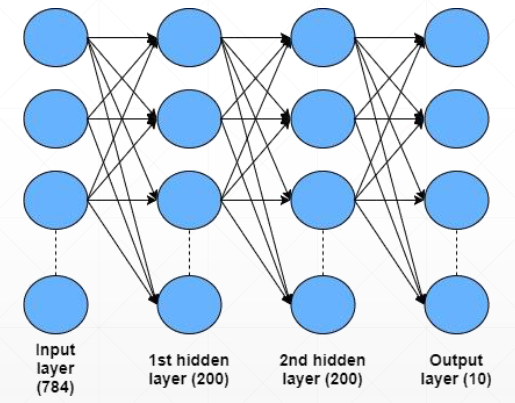

In [0]:
#注意参数顺序，输出是200，输入是784
w1,b1=torch.randn(200,784,requires_grad=True),torch.randn(200,requires_grad=True)
w2,b2=torch.randn(200,200,requires_grad=True),torch.randn(200,requires_grad=True)
w3,b3=torch.randn(10,200,requires_grad=True),torch.randn(10,requires_grad=True)

In [3]:
#初始化很重要，不加可能会不收敛
torch.nn.init.kaiming_normal_(w1) #凯明的初始化方法
torch.nn.init.kaiming_normal_(w2)
torch.nn.init.kaiming_normal_(w3)

tensor([[ 0.0035,  0.1014, -0.0175,  ...,  0.0059,  0.0378,  0.1596],
        [-0.0755, -0.0902, -0.0388,  ...,  0.0690,  0.2342, -0.1109],
        [-0.0518,  0.1989,  0.1145,  ...,  0.1274,  0.0069, -0.0583],
        ...,
        [-0.1391, -0.0236,  0.0157,  ...,  0.1356, -0.0018,  0.0320],
        [ 0.0128, -0.0160,  0.1446,  ..., -0.0239, -0.0216, -0.0415],
        [ 0.0124, -0.2328, -0.1789,  ..., -0.0717, -0.0126,  0.1702]],
       requires_grad=True)

In [0]:
def forward(x):
    x=x@w1.t()+b1 #b1是200，要自动扩展
    x=F.relu(x)
    x=x@w2.t()+b2
    x=F.relu(x)
    x=x@w3.t()+b3
    x=F.relu(x) #没经过softmax和sigmoid的就是logits，relu可有可没有 
    return x

3、训练与评估：


In [5]:
optimizer=optim.SGD([w1,b1,w2,b2,w3,b3],lr=learning_rate) #优化器
criteon=nn.CrossEntropyLoss() #交叉熵损失，不用再多加softmax了，和F.cross_entropy一样

for epoch in range(epochs):
    for batch_idx,(data,target) in enumerate(train_loader):
        data=data.view(-1,28*28)

        logits=forward(data)
        loss=criteon(logits,target) #损失
        # loss=F.cross_entropy(logits,target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step() #更新
       
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                       100. * batch_idx / len(train_loader), loss.item()))

    test_loss = 0
    correct = 0
    for data, target in test_loader:
        data = data.view(-1, 28 * 28)
        logits = forward(data)
        test_loss += criteon(logits, target).item()

        pred = logits.data.max(1)[1]
        correct += pred.eq(target.data).sum()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

Train Epoch: 0 [0/60000 (0%)]	Loss: 3.538675
Train Epoch: 0 [20000/60000 (33%)]	Loss: 0.834864
Train Epoch: 0 [40000/60000 (67%)]	Loss: 0.546448

Test set: Average loss: 0.0019, Accuracy: 8893/10000 (88%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.328865
Train Epoch: 1 [20000/60000 (33%)]	Loss: 0.458407
Train Epoch: 1 [40000/60000 (67%)]	Loss: 0.307354

Test set: Average loss: 0.0014, Accuracy: 9169/10000 (91%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.388060
Train Epoch: 2 [20000/60000 (33%)]	Loss: 0.334696
Train Epoch: 2 [40000/60000 (67%)]	Loss: 0.217570

Test set: Average loss: 0.0012, Accuracy: 9305/10000 (93%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.250966
Train Epoch: 3 [20000/60000 (33%)]	Loss: 0.300960
Train Epoch: 3 [40000/60000 (67%)]	Loss: 0.303266

Test set: Average loss: 0.0011, Accuracy: 9374/10000 (93%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.222222
Train Epoch: 4 [20000/60000 (33%)]	Loss: 0.224267
Train Epoch: 4 [40000/60000 (67%)]	Loss: 0.223342

Test set: Average loss: 0.0010

### 高层API实现全连接层mnist

高层实现，nn.Linear()

ReLU：Test set: Average loss: 0.0011, Accuracy: 9373/10000 (93%)，偶尔也不稳定，也有65%、84%、93%

LeakyReLU：Test set: Average loss: 0.0011, Accuracy: 9372/10000 (93%)

In [0]:
import  torch
import  torch.nn as nn
import  torch.nn.functional as F
import  torch.optim as optim
from    torchvision import datasets, transforms

batch_size=200
learning_rate=0.01
epochs=10

# 加载数据
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('mnist_data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('mnist_data', train=False, transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])),
    batch_size=batch_size, shuffle=True)

# 网络结构
class MLP(nn.Module): #继承自nn.Module类

    def __init__(self): #初始化，传自己的参数，这里不需要
        super(MLP, self).__init__()

        self.model = nn.Sequential( #nn.Sequential可以添加任何继承自nn.Module的类
            nn.Linear(784, 200),
            nn.ReLU(inplace=True), #inplace可以节省多出来的内存
            nn.Linear(200, 200),
            nn.ReLU(inplace=True),
            nn.Linear(200, 10),
            nn.ReLU(inplace=True),
        )

    def forward(self, x): #实现前向传播，不用实现反向传播
        x = self.model(x) #使用了model.forward
        return x

# 训练
net = MLP() #实例化
#不需要认为w b了，nn.Module会自动把这些tensor加载到parameters里去一次返回
#w b也不用初始化了，Linear里包含了
optimizer = optim.SGD(net.parameters(), lr=learning_rate) 
criteon = nn.CrossEntropyLoss()

for epoch in range(epochs):

    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.view(-1, 28*28)

        logits = net(data) #给网络送入数据
        loss = criteon(logits, target)

        optimizer.zero_grad()
        loss.backward()
        # print(w1.grad.norm(), w2.grad.norm())
        optimizer.step()

        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                       100. * batch_idx / len(train_loader), loss.item()))

    test_loss = 0
    correct = 0
    for data, target in test_loader:
        data = data.view(-1, 28 * 28)
        logits = net(data)
        test_loss += criteon(logits, target).item()

        pred = logits.data.max(1)[1]
        correct += pred.eq(target.data).sum()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

Train Epoch: 0 [0/60000 (0%)]	Loss: 2.306395
Train Epoch: 0 [20000/60000 (33%)]	Loss: 2.124984
Train Epoch: 0 [40000/60000 (67%)]	Loss: 1.674785

Test set: Average loss: 0.0073, Accuracy: 6147/10000 (61%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 1.498421
Train Epoch: 1 [20000/60000 (33%)]	Loss: 1.267947
Train Epoch: 1 [40000/60000 (67%)]	Loss: 1.245435

Test set: Average loss: 0.0053, Accuracy: 6522/10000 (65%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 1.078921


### GPU全连接层mnist

LeakyReLU：Test set: Average loss: 0.0011, Accuracy: 9345/10000 (93%)，几次GPU训练稳定在这个值

ReLU：Test set: Average loss: 0.0021, Accuracy: 8530/10000 (85%)，几次GPU训练不稳定，63%、73%、85%、93%都有过

In [11]:
import  torch
import  torch.nn as nn
import  torch.nn.functional as F
import  torch.optim as optim
from  torchvision import datasets, transforms

batch_size=200
learning_rate=0.01
epochs=10

# 加载数据
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('mnist_data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('mnist_data', train=False, transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])),
    batch_size=batch_size, shuffle=True)

# 网络结构
class MLP(nn.Module): #继承自nn.Module类

    def __init__(self): #初始化，传自己的参数，这里不需要
        super(MLP, self).__init__()

        self.model = nn.Sequential( #nn.Sequential可以添加任何继承自nn.Module的类
            nn.Linear(784, 200),
            nn.LeakyReLU(inplace=True), #inplace可以节省多出来的内存
            nn.Linear(200, 200),
            nn.LeakyReLU(inplace=True),
            nn.Linear(200, 10),
            nn.LeakyReLU(inplace=True),
        )

    def forward(self, x): #实现前向传播，不用实现反向传播
        x = self.model(x) #使用了model.forward
        return x

# 训练
device = torch.device('cuda:0,1') #GPU
net = MLP().to(device) #GPU
#不需要认为w b了，nn.Module会自动把这些tensor加载到parameters里去一次返回
#w b也不用初始化了，Linear里包含了
optimizer = optim.SGD(net.parameters(), lr=learning_rate) 
criteon = nn.CrossEntropyLoss().to(device) #GPU

for epoch in range(epochs):

    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.view(-1, 28*28)
        data, target = data.to(device), target.cuda() #GPU

        logits = net(data) #给网络送入数据
        loss = criteon(logits, target)

        optimizer.zero_grad()
        loss.backward()
        # print(w1.grad.norm(), w2.grad.norm())
        optimizer.step()

        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                       100. * batch_idx / len(train_loader), loss.item()))

    test_loss = 0
    correct = 0
    for data, target in test_loader:
        data = data.view(-1, 28 * 28)
        data, target = data.to(device), target.cuda() #GPU
        logits = net(data)
        test_loss += criteon(logits, target).item()

        pred = logits.data.max(1)[1]
        correct += pred.eq(target.data).sum()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

Train Epoch: 0 [0/60000 (0%)]	Loss: 2.297979
Train Epoch: 0 [20000/60000 (33%)]	Loss: 2.021637
Train Epoch: 0 [40000/60000 (67%)]	Loss: 1.445032

Test set: Average loss: 0.0056, Accuracy: 7203/10000 (72%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 1.075741
Train Epoch: 1 [20000/60000 (33%)]	Loss: 0.943719
Train Epoch: 1 [40000/60000 (67%)]	Loss: 0.738639

Test set: Average loss: 0.0033, Accuracy: 8211/10000 (82%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.629387
Train Epoch: 2 [20000/60000 (33%)]	Loss: 0.674149
Train Epoch: 2 [40000/60000 (67%)]	Loss: 0.717169

Test set: Average loss: 0.0028, Accuracy: 8337/10000 (83%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.664478
Train Epoch: 3 [20000/60000 (33%)]	Loss: 0.521124
Train Epoch: 3 [40000/60000 (67%)]	Loss: 0.343371

Test set: Average loss: 0.0017, Accuracy: 8978/10000 (89%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.324872
Train Epoch: 4 [20000/60000 (33%)]	Loss: 0.310015
Train Epoch: 4 [40000/60000 (67%)]	Loss: 0.256808

Test set: Average loss: 0.0015